## Thresholding data to remove outlier frames

#### The purpose of the script is to use standardized data from step 2 and remove outliers.

- Based on Burgess,H.A. et al. (2007) J. Neurosci., 27, 4984–4994. a zebrafish larvae can move about 2.5 times it's body length during a startle response (120 frames at 1000 frames/second)
- Zfin data indicates that the average zf larval length at 5 dpf is 3.9 mm

Therefore the max distance moved threshold is ~3.25 mm per frame in our system ( 25 frames per second ).
 - (1s/25f) * (3.9mm * 2.5) / (120f/1000f/1s)

by: Dr. Adrian Green, *Fall 2021*

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

# import math and stat libraries
from scipy.stats import ks_2samp, zscore
import math

from Green_scripts_v1 import agg_by_time, load_obj

### Analyze data to find larvae with significantly different distance moved.

#### 1. Compare treated and control using KS test
 - collapse data to acclmation/background (**A**), light phase (**L**), dark phase (**D**)
 - see Reif,D.M. et al. (2016) Arch Toxicol, 90, 1459–1470

#### Load data

In [2]:
# load all location data for processing
basedirname = '/home2/ajgreen4/ZF_Projects/HTS_Behavior_Project'
data_path = basedirname + '/results/'

# Loading the dataset 
all_movement = load_obj(data_path, "5dpf_2nd_cycle_movement-etho_data_Step2_standardize_analyze_output")

# load all location data for processing
pcwKey = pd.read_csv(basedirname + "/Raw_Data_Files/plateTable.csv")

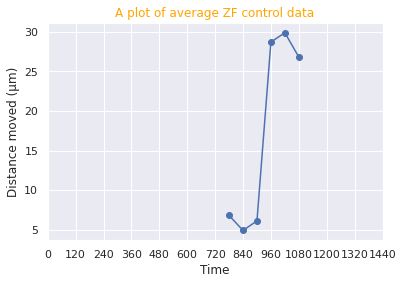

In [3]:
test = agg_by_time(all_movement, 0, 1560, 60, ['PlateID', 'ChemID', 'Well', 'Conc'])

df = test.groupby(by=['Trial time'], 
                 sort=False)['Distance moved'].mean().reset_index()

# plot
plt.plot('Trial time', 'Distance moved', data=df, linestyle='-', marker='o')
# Add titles
plt.title("A plot of average ZF control data", loc='center', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.xticks( range(0,1560,120) )   # Put x axis ticks every 60 units.
plt.ylabel("Distance moved (µm)")

plt.show()

In [4]:
%%time
# Remove experiments that don't use Tropical5D zebrafish
print(all_movement.shape)
drop_chems = ['Vitality tablets', 'TCDD Wildtype', 'TCDD Wfikkn1', 'Wfikkn1 Wildtype']

chem = pcwKey.loc[(pcwKey['Chemical.Name'].isin(drop_chems)), 'ChemID'].unique()
all_movement = all_movement[~all_movement['ChemID'].isin(chem)]
print(all_movement.shape)

(33993000, 10)
(30825000, 10)
CPU times: user 4.28 s, sys: 2.27 s, total: 6.55 s
Wall time: 6.51 s


### All movement based

In [5]:
all_movement_DM = all_movement['Distance moved'].copy()

print('Maximum movement in one frame: ', all_movement_DM[all_movement_DM.idxmax()], 'mm')

Maximum movement in one frame:  5.68944 mm


In [6]:
print('Number of outlier frames: ' + str(np.sum(all_movement_DM>3.25))) # count 
outlier_rows = np.where(all_movement_DM>3.25)[0]

Number of outlier frames: 5445


In [7]:
all_movement_o = all_movement.copy()
all_movement_o.loc[(all_movement_o.index[outlier_rows]), 'Distance moved'] = 3.25

print('All data: ', all_movement.shape)
print('Cleaned data: ', all_movement_o.shape)

All data:  (30825000, 10)
Cleaned data:  (30825000, 10)


In [8]:
all_movement_DM = all_movement_o['Distance moved'].copy()

print('Maximum movement in one frame: ', all_movement_DM[all_movement_DM.idxmax()], 'mm')

Maximum movement in one frame:  3.25 mm


In [9]:
all_movement_o.to_csv(data_path + "5dpf_2nd_cycle_movement-etho_data_Step3_threshold_output_cleaned.csv", index=False)